Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# @title TIPS Demo notebook

#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at

#  https://www.apache.org/licenses/LICENSE-2.0

#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

### Imports and functions

Please follow the installation guide before you run the following cells.

In [1]:
import glob
import io
import os
import mediapy as media
import numpy as np
from PIL import Image
from PIL import Image
import tensorflow_text
from tips.pytorch import image_encoder
from tips.pytorch import text_encoder
from tips.scenic.utils import feature_viz
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

IMAGE_MEAN = (0, 0, 0)
IMAGE_STD = (1.0, 1.0, 1.0)
PATCH_SIZE = 14
MAX_LEN = 64
VOCAB_SIZE = 32000


def load_image_bytes(file_name):
  with open(file_name, 'rb') as fd:
    image_bytes = io.BytesIO(fd.read())
    pil_image = Image.open(image_bytes)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
    input_tensor = transform(pil_image)
    input_batch = input_tensor.unsqueeze(0)

  return input_batch

/Users/francischen/Documents/tips/pytorch/image_encoder.py:175: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")


### Configure the TIPS model.

In [2]:
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']

# Add your images in this directory.
image_dir = '../scenic/images/'  # @param {type: "string"}
image_paths = glob.glob(os.path.join(image_dir, '*'))
# The text inputs to be contrasted.
text_inputs = [
    'A ship',
    'holidays',
    'a toy dinosaur',
    'Two astronauts',
    'A streetview image of a fastfood restaurant',
    'a cat',
    'a dog',
    'two cows',
]

# Add the checkpoints and tokenizer path.
image_encoder_checkpoint = 'tips_oss_s14_highres_distilled_vision.npz'  # @param {type: "string"}
text_encoder_checkpoint = 'tips_oss_s14_highres_distilled_text.npz'  # @param {type: "string"}
tokenizer_path = 'tokenizer.model'  # @param {type: "string"}

### Run Vision Encoder Inference.

In [3]:
# Load checkpoint.
weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []

with torch.no_grad():
  # Load the vision encoder.
  model_image = image_encoder.vit_small(
      img_size=image_size,
      patch_size=PATCH_SIZE,
      ffn_layer=ffn_layer,
      block_chunks=0,
      init_values=1.0,
      interpolate_antialias=True,
      interpolate_offset=0.0,
  )
  model_image.load_state_dict(weights_image)

  for image_path in image_paths:
    input_batch = load_image_bytes(image_path)
    output = model_image(input_batch)
    cls_token = feature_viz.normalize(
        output[0][0][0]
    )  # Choose the first CLS token.
    spatial_feature = torch.reshape(
        output[2],
        (1, int(image_size / PATCH_SIZE), int(image_size / PATCH_SIZE), -1),
    )
    spatial_features.append(spatial_feature)
    embeddings_image.append(cls_token)

### Run Text Encoder Inference.

In [4]:
def get_text_config(v):
  return {
      'hidden_size': {'S': 384, 'B': 768, 'L': 1024, 'So400m': 1152, 'g': 1536}[
          v
      ],
      'mlp_dim': {'S': 1536, 'B': 3072, 'L': 4096, 'So400m': 4304, 'g': 6144}[
          v
      ],
      'num_heads': {'S': 6, 'B': 12, 'L': 16, 'So400m': 16, 'g': 24}[v],
      'num_layers': {'S': 12, 'B': 12, 'L': 12, 'So400m': 27, 'g': 12}[v],
  }


with open(text_encoder_checkpoint, 'rb') as fin:
  inbuffer = io.BytesIO(fin.read())
np_weights_text = np.load(inbuffer, allow_pickle=False)

weights_text = {}
for key, value in np_weights_text.items():
  weights_text[key] = torch.from_numpy(value)

temperature = weights_text.pop('temperature')
with torch.no_grad():
  # Load the text encoder.
  model_text = text_encoder.TextEncoder(
      get_text_config(variant),
      vocab_size=VOCAB_SIZE,
  )
  model_text.load_state_dict(weights_text)
  tokenizer = text_encoder.Tokenizer(tokenizer_path)

  text_ids, text_paddings = tokenizer.tokenize(text_inputs, max_len=MAX_LEN)
  embeddings_text = model_text(
      torch.from_numpy(text_ids), torch.from_numpy(text_paddings)
  )
  embeddings_text = feature_viz.normalize(embeddings_text)

### Visualize the results.

Input image,"a toy dinosaur, prob: 100.0%"

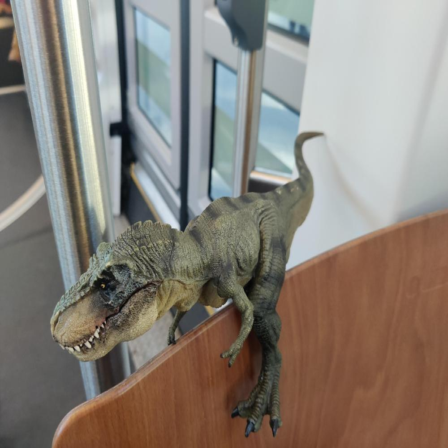
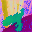

Input image,"a cat, prob: 100.0%"

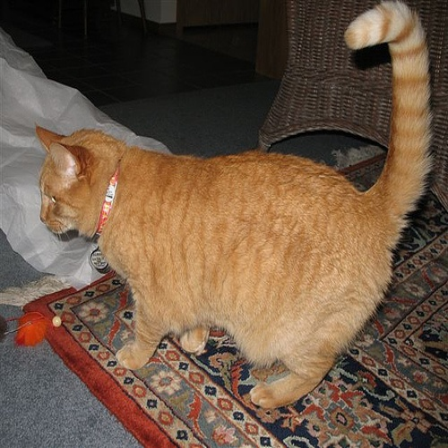
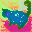

In [5]:
for idx, embedding_image in enumerate(embeddings_image):
  # Compute cosine similariy.
  cos_sim = F.softmax(
      ((embedding_image.unsqueeze(0) @ embeddings_text.T) / temperature), dim=-1
  )
  label_idxs = torch.argmax(cos_sim, axis=-1)
  cos_sim_max = torch.max(cos_sim, axis=-1)
  label_predicted = text_inputs[label_idxs[0]]
  similarity = cos_sim_max.values[0]

  # Visualize the results.
  pca_obj = feature_viz.PCAVisualizer(spatial_features[idx])
  image_pca = pca_obj(spatial_features[idx])[0]

  with open(image_paths[idx], 'rb') as f:
    image = Image.open(f)
    image = image.resize((image_size, image_size), Image.Resampling.BILINEAR)
    image = np.array(image).astype(np.float32) / 255.0

  media.show_images(
      [image, image_pca],
      width=image_size,
      titles=[
          'Input image',
          f'{label_predicted},  prob: {similarity*100:.1f}%',
      ],
  )